We will cover:
 -Simple linear regression
 -R obust linear regression
 -Hierarchical linear regression
 -Polynomial regression
 -Multiple linear regression
 -Interactions
 -Variable variance

## The core of linear regression models

In [1]:
# l'equation linéaire de ce modèle est connue et s'exprime sous la forme Y = α + β*X + ϵ
# d'un point de vue analytique on le resoud par la formule des moindres carrés
# numeriquequement il peut etre resolu par la methode bayesienne et dans ce cas Y ~ N(α + β*X , ϵ )
# il suffit ainsi de trouver les prior des paramètre notament α, β, ϵ
# α suit une loi normale, β une loi normale et ϵ la loi Normale positive ou et par ordre decroissant de preference la loi gamma, la loi Cauchy positive, la loi uniforme


In [3]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from theano import shared

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


$$ \alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \ \beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \ \epsilon \sim | \mathcal{N}(0, \sigma_\epsilon) | $$

$$y \sim \mathcal{N}(\mu = \alpha + x \beta, \epsilon)$$

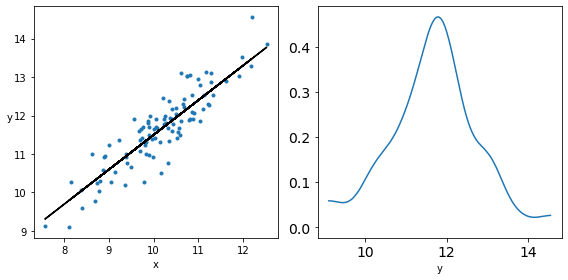

In [4]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

y = y_real + eps_real
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [5]:
# by setting a variable deterministic, we ask to pymc3 engine to compute that variable and store it

In [6]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x) # we could have ommited this instruction but at that time the x variable 
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) # will be calculated but not stored y_pred = pm.Normal('y_pred', mu= α + β * x, sd=ϵ, observed=y)
    trace_g = pm.sample(2000, tune=1000)
    
# trace are dictionnary with parameter as key and posterior predictive sample as value an ndarray
# len on dictionnary will give the number of keys
# shape on ndarray will give the length of each dimension as a tuple that you can unpack
# ndim on ndarray will give the number of dimension as an integer value
# size on ndarray will give you the total number of elements

C:\Users\bomyr\AppData\Local\Temp\ipykernel_31076\3098967380.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


ContextualVersionConflict: (typing-extensions 4.1.1 (c:\users\bomyr\miniconda3\lib\site-packages), Requirement.parse('typing-extensions<4,>=3.7.4.3'), {'arviz'})

In [ ]:
!ipython profile locate default

In [ ]:
 # to explore the results of our inference
with model_g:
    az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])

## Linear models and high autocorrelation

D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


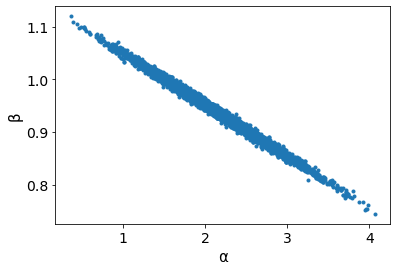

In [28]:
# this model lead to α and β that are highly correlated
with model_g:
    az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.8})
    
# An increase in the slope means a decrease of the intercept and vice versa. Both parameters
# are going to be correlated by definition of the model. This can be problematic for samplers such as
# Metropolis-Hastings and to a lesser extent NUTS.

In [29]:
# to remove autocorrelation we can modify data by centering them before runing
# for many situations the value of yi when xi =0 i.e the intercept is meaningless, then the centering of data can give a
# valuable information to the modeler, in fact the intercept will be always equal the value of yi for the mean of x
# we have the choice to report the estimated parameters in terms of centered data or in trms of uncentered data
# α = α' - β'* mean(x)

# we can go futher by standartising, that allow to easily interpretation of results in term of Z-Score

### Interpreting and visualizing the posterior

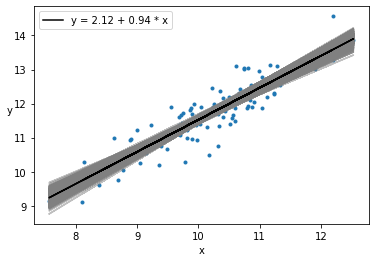

In [30]:
# we use az.plot_trace and summary

with model_g:
    plt.plot(x, y, 'C0.')
    alpha_m = trace_g['α'].mean()
    beta_m = trace_g['β'].mean()
    draws = range(0, len(trace_g['α']), 10)
    plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]* x[:, np.newaxis], c='gray', alpha=0.5)
    plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()

In [31]:
 trace_g['β'][draws].shape

(800,)

In [32]:
x[:, np.newaxis].shape

(100, 1)

In [33]:
(trace_g['β'][draws]* x[:, np.newaxis]).shape

(100, 800)

In [34]:
range(0, len(trace_g['α']), 10)

range(0, 8000, 10)

D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


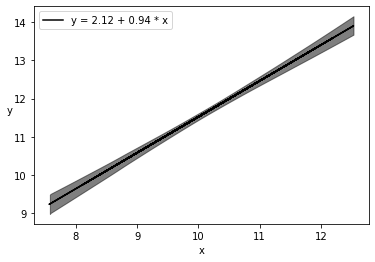

In [35]:
# we will plot hdi or hdp 
plt.plot(x, alpha_m + beta_m * x, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
sig=az.plot_hdi(x, trace_g['μ'], hdi_prob=0.94, color='k')
#sig = az.plot_hdi(x, trace_g['μ'], credible_interval=0.98, color='k')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


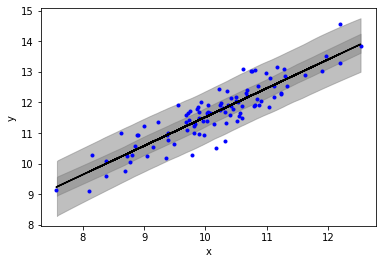

In [36]:
# one more option is to visualize 50% and 94% HDP that is where we expect to see the 94% and 50% of future data according to our model
# Getting the posterior predictive samples is easy in PyMC3 using the sample_posterior_predictive() function:
ppc = pm.sample_posterior_predictive(trace_g,samples=2000,model=model_g)

# Now, we can plot the results:
with model_g:
    plt.plot(x, y, 'b.')
    plt.plot(x, alpha_m + beta_m * x, c='k',
             label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    az.plot_hdi(x, ppc['y_pred'], hdi_prob=0.5, color='gray')
    az.plot_hdi(x, ppc['y_pred'], color='gray')
    plt.xlabel('x')
    plt.ylabel('y', rotation=90)

## Pearson corellation coeficient

In [37]:
# coeficient  de corelation = degree of linear dependancy between two variables var(y)=β * σx / σy = cov(x,y)/(σx*σy)
# coeficient de détermination r² = R² = variance ^y / variance y = la proportion de la variation de y expliqué par la variable x
# in bayesian analysis R² = var(^y) / [var(y)+ var(^y-y)]

In [38]:
az.r2_score(y, ppc['y_pred']) #this is tjhe bayesian R²

r2        0.786460
r2_std    0.006192
dtype: float64

## Pearson coefficient from a multivariate Gaussian

Text(-0.05, 0.5, 'x_2')

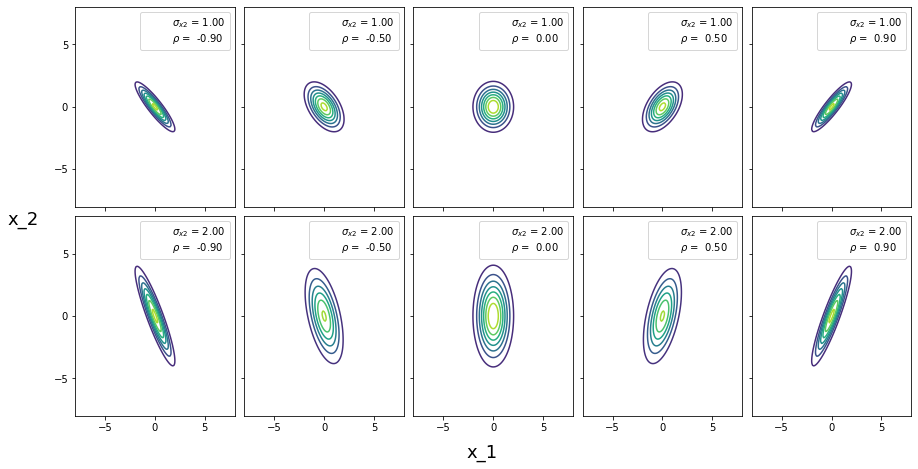

In [39]:
# the following code generate bivariate guaussian distribution with means fixed at (0, 0). One of the standard deviations is fixed , while the other takes
# the values 1 or 2 and different values for the Pearson correlation coefficient:

sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]
k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l
f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
                [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0, label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ =  {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)

In [40]:
# now that we know the multivariate guaussian distribution, we can fix prior over covariance matrix or correlation matrix or standard and correlation
# - the Whishart distribution is the conjugate prior of the inverse covariance matrix it is a generalisation of gamma or chi 2
# -LKJ prior is the concjugate prior of the correlation matrix
# - 

In [41]:
np.stack((x,y)).T.mean(1)

array([10.7313142 , 11.76034322, 11.00127412, 11.04565744,  9.92618565,
       10.33552864, 11.88973157,  9.6536827 , 10.57685219, 10.71864123,
        9.81106553, 10.53436625, 11.47324831,  9.83744627, 11.36646104,
        9.22835794, 10.67013221,  8.99555166, 11.82590026, 11.28415931,
       10.4514591 , 10.29977739, 12.18546581, 12.74437025,  9.21013122,
       11.75342386, 12.26554566, 10.83716875,  9.54372335, 11.70276692,
       10.40521053, 10.07708702,  9.4096516 , 11.06170921, 11.33535499,
       10.15447966, 10.96521993,  9.7214796 , 11.92671852, 10.97974997,
       10.52479983, 10.43143418, 11.38865228, 11.88600471, 11.265694  ,
       10.72156724, 10.87165894, 11.86252503, 11.00090957, 11.55272461,
       10.53043165,  8.34884166, 11.45125382, 12.74029498, 11.11707266,
       10.80150833, 10.83012335, 10.86967404, 10.83793577,  9.9053675 ,
       10.07016078, 10.11604155, 11.11459166, 10.3936677 , 11.34258029,
       10.56513907, 11.96992578, 11.33281141, 13.37755859,  8.59

In [42]:
data = np.stack((x, y)).T # np.vstack then transposition
with pm.Model() as pearson_model:
    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2) # mean per variable (02)
    σ_1 = pm.HalfNormal('σ_1', 10)  # standard deviation of x
    σ_2 = pm.HalfNormal('σ_2', 10)  # standard deviation of y
    ρ = pm.Uniform('ρ', -1., 1.)    # coefficient of correlation between -1 and 1
    r2 = pm.Deterministic('r2', ρ**2) # deterministic variable to be compute and store the coefficient of determination
    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ], [σ_1*σ_2*ρ, σ_2**2])) # covariance matrix
    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data) # multivariate normal distribution
    trace_p = pm.sample(1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/175162264.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_p = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ, σ_2, σ_1, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 86 seconds.


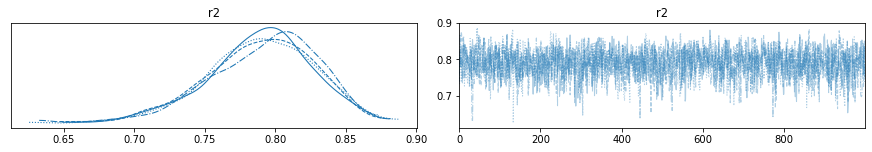

In [43]:
with pearson_model:
    az.plot_trace(trace_p, var_names=['r2'])

In [44]:
az.summary(trace_p, var_names=['r2'])

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r2,0.79,0.038,0.721,0.859,0.001,0.001,1940.0,2247.0,1.0


# Robust linear regression

In [45]:
data = pd.read_csv("C:/Users/kamguia_l/Documents/data/anscombe.csv")

In [46]:
data.tail()

,group,x,y
39,IV,8.0,5.25
40,IV,19.0,12.50
41,IV,8.0,5.56
42,IV,8.0,7.91
43,IV,8.0,6.89


In [47]:
data.head()

,group,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


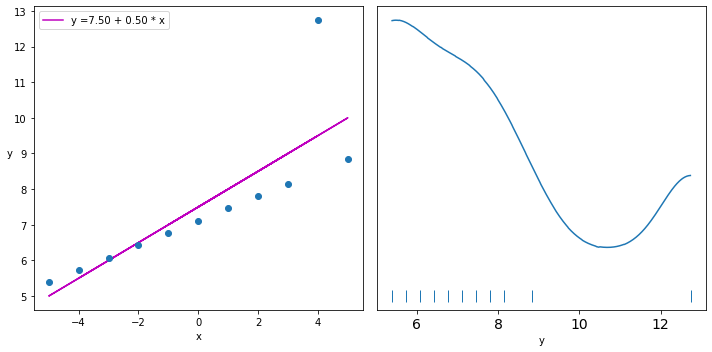

In [48]:
ans=data
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()
# Now, let's check what this little tiny dataset looks like:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2] # here stats.linregress(x,y) is a function of regression that return value like slope, intercept, r_value, p_value stderr
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'm', label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x') # in this order so we can write  slope, intercept, r, p, se = linregress(x, y)
ax[0].plot(x_3, y_3, 'C0o') # plot point
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [49]:
help(stats.linregress)

Help on function linregress in module scipy.stats._stats_mstats_common:

linregress(x, y=None, alternative='two-sided')
    Calculate a linear least-squares regression for two sets of measurements.
    
    Parameters
    ----------
    x, y : array_like
        Two sets of measurements.  Both arrays should have the same length.  If
        only `x` is given (and ``y=None``), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension. In
        the case where ``y=None`` and `x` is a 2x2 array, ``linregress(x)`` is
        equivalent to ``linregress(x[0], x[1])``.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the alternative hypothesis. Default is 'two-sided'.
        The following options are available:
    
        * 'two-sided': the slope of the regression line is nonzero
        * 'less': the slope of the regression line is l

In [53]:
# Now we will use t student probability when modeling model-g in order to take into account

with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', sigma=5)
    ν_ = pm.Exponential('ν_', 1/29) #normality parameter; other specification could be gamma(2, 0.1) or gamma(mu=20, sd=15)
    ν = pm.Deterministic('ν', ν_ + 1) # shifted exponential distribution is more suitable for distribution with high outliers
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3, sd=ϵ, nu=ν, observed=y_3)
    trace_t = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1359417982.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 1080x720 with 0 Axes>

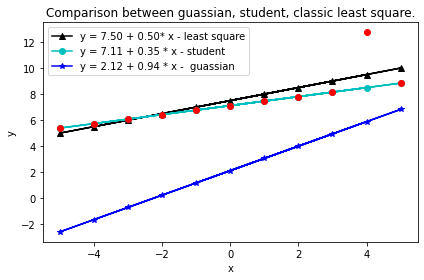

<Figure size 1080x720 with 0 Axes>

In [80]:
# now we will put on the same graph robust and non robust regression

beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c*x_3), linestyle ='-', color='k', marker='^', label = f'y = {alpha_c:.2f} + {beta_c:.2f}* x - least square')
alpha_t =trace_t['α'].mean()
beta_t = trace_t['β'].mean()
alpha_g =trace_g['α'].mean()
beta_g = trace_g['β'].mean()
plt.plot(x_3, (alpha_t + beta_t * x_3), linestyle ='-', color='c', marker='o', label = f'y = {alpha_t:.2f} + {beta_t:.2f} * x - student')
plt.plot(x_3, (trace_g['α'].mean() + trace_g['β'].mean() * x_3), linestyle = '-', color='b', marker = '*', label = f'y = {alpha_g:.2f} + {beta_g:.2f} * x -  guassian')
plt.plot(x_3,y_3, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.title("Comparison between guassian, student, classic least square.")
plt.tight_layout()
plt.figure(figsize=(15,10))

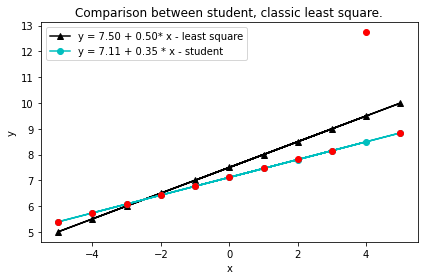

In [82]:
# now we will put on the same graph robust and non robust regression

beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c*x_3), linestyle ='-', color='k', marker='^', label = f'y = {alpha_c:.2f} + {beta_c:.2f}* x - least square')
alpha_t =trace_t['α'].mean()
beta_t = trace_t['β'].mean()
alpha_g =trace_g['α'].mean()
beta_g = trace_g['β'].mean()
plt.plot(x_3, (alpha_t + beta_t * x_3), linestyle ='-', color='c', marker='o', label = f'y = {alpha_t:.2f} + {beta_t:.2f} * x - student')
plt.plot(x_3,y_3, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.title("Comparison between student, classic least square.")
plt.tight_layout()


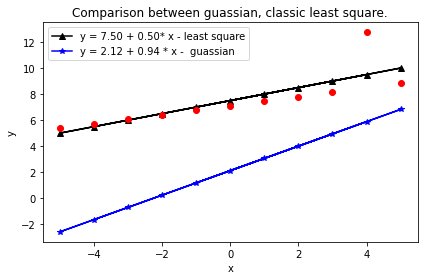

In [84]:
# now we will put on the same graph robust and non robust regression

beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c*x_3), linestyle ='-', color='k', marker='^', label = f'y = {alpha_c:.2f} + {beta_c:.2f}* x - least square')
alpha_g =trace_g['α'].mean()
beta_g = trace_g['β'].mean()
plt.plot(x_3, (trace_g['α'].mean() + trace_g['β'].mean() * x_3), linestyle = '-', color='b', marker = '*', label = f'y = {alpha_g:.2f} + {beta_g:.2f} * x -  guassian')
plt.plot(x_3,y_3, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.title("Comparison between guassian, classic least square.")
plt.tight_layout()

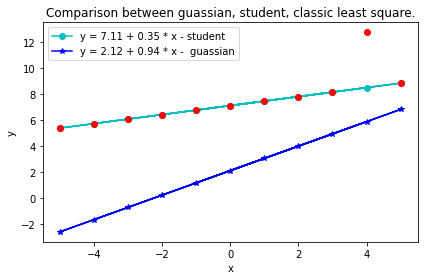

In [86]:
# now we will put on the same graph robust and non robust regression

# beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
# plt.plot(x_3, (alpha_c + beta_c*x_3), linestyle ='-', color='k', marker='^', label = f'y = {alpha_c:.2f} + {beta_c:.2f}* x - least square')
alpha_t =trace_t['α'].mean()
beta_t = trace_t['β'].mean()
alpha_g =trace_g['α'].mean()
beta_g = trace_g['β'].mean()
plt.plot(x_3, (alpha_t + beta_t * x_3), linestyle ='-', color='c', marker='o', label = f'y = {alpha_t:.2f} + {beta_t:.2f} * x - student')
plt.plot(x_3, (trace_g['α'].mean() + trace_g['β'].mean() * x_3), linestyle = '-', color='b', marker = '*', label = f'y = {alpha_g:.2f} + {beta_g:.2f} * x -  guassian')
plt.plot(x_3,y_3, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.title("Comparison between guassian, student, classic least square.")
plt.tight_layout()


In [89]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.summary(trace_t, var_names=varnames)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.112,7.117,0.000,0.000,3619.0,3903.0,1.0
β,0.345,0.000,0.345,0.346,0.000,0.000,4008.0,3675.0,1.0
ϵ,0.003,0.002,0.001,0.006,0.000,0.000,1310.0,528.0,1.0
ν,1.213,0.202,1.000,1.588,0.003,0.002,3186.0,2241.0,1.0


D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


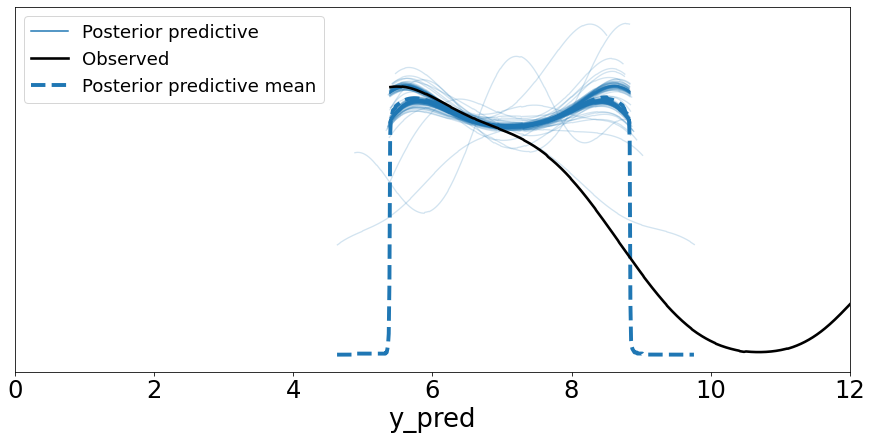

In [92]:
# lets run a posterior predictive 

with model_t:
    ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t,random_seed=2) # Generate posterior predictive samples from a model given a trace.
    data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc) # Convert pymc3 data into an InferenceData object.
    ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
    plt.xlim(0, 12)

## Hierachical Linear regression

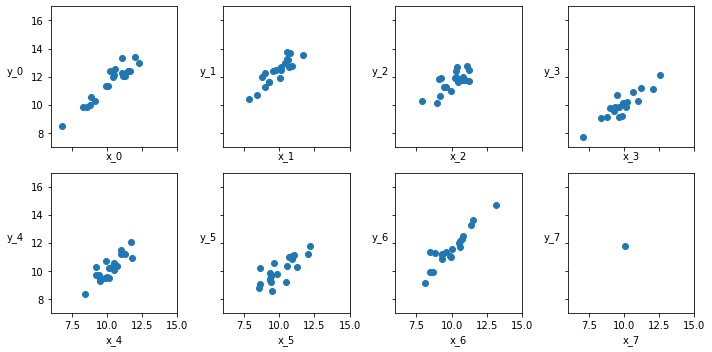

In [95]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax) # Return a contiguous flattened array, similar at reshape(-1)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [96]:
x_centered = x_m - x_m.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    trace_up = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/3613453844.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_up = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


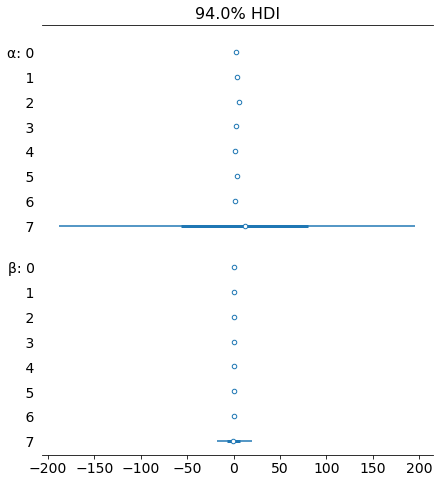

In [97]:
with unpooled_model:
    az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)

In [98]:
with pm.Model() as hierachical_model:
    #hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu = 0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10) # mu_beta follow a normal function
    β_σ = pm.HalfNormal('β_σ', sd=10) #
    #priors
    α_tmp = pm.Normal('α_tm', mu=α_μ_tmp, sd=α_σ_tmp, shape=M) # α ~ Normal(μ_α, σ_α)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M) # β ~ Normal ( μ_β, σ_β)
    ϵ = pm.HalfCauchy('ϵ', 5)  # or Half normal
    ν = pm.Exponential('ν', 1/30) # or shifted exponential
    
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
    trace_hm = pm.sample(1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/2694329092.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_hm = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tm, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6245127237566122, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


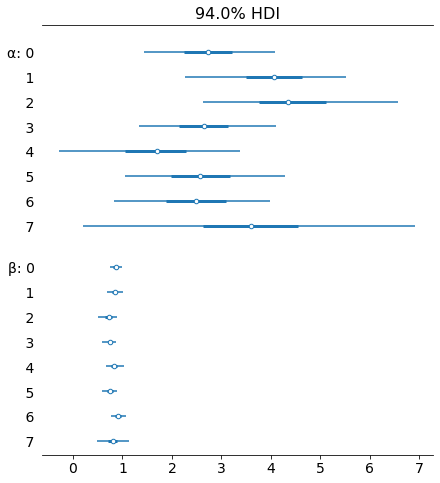

In [99]:
with hierachical_model:
    az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:329: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


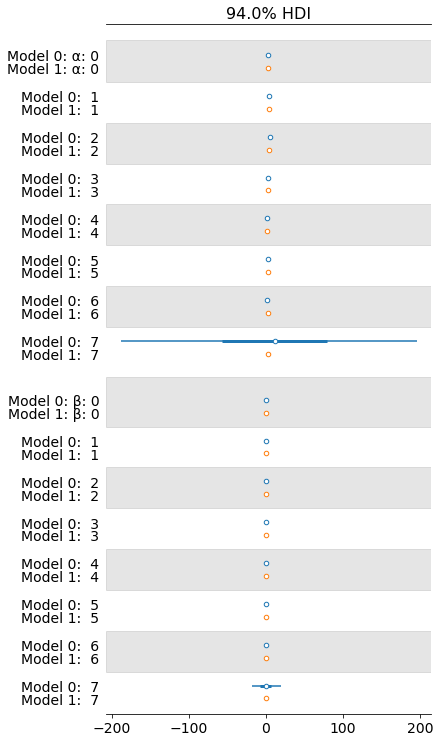

In [100]:
# we will compare both models here
with unpooled_model, hierachical_model:
    az.plot_forest([trace_up, trace_hm], var_names=['α', 'β'], combined=True)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

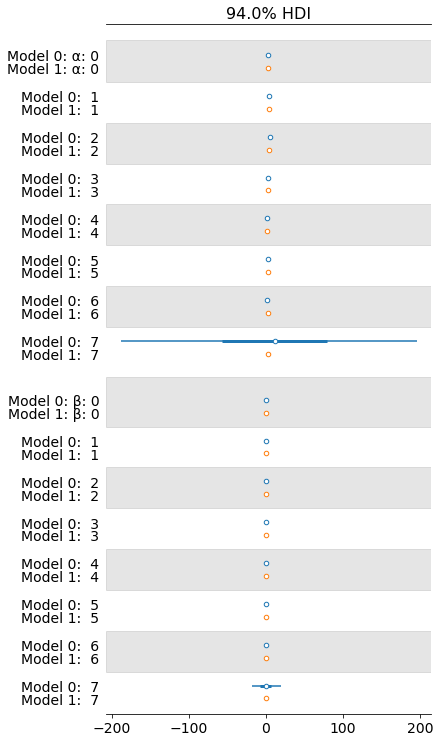

In [101]:
az.plot_forest([trace_up, trace_hm], var_names=['α', 'β'], combined=True)

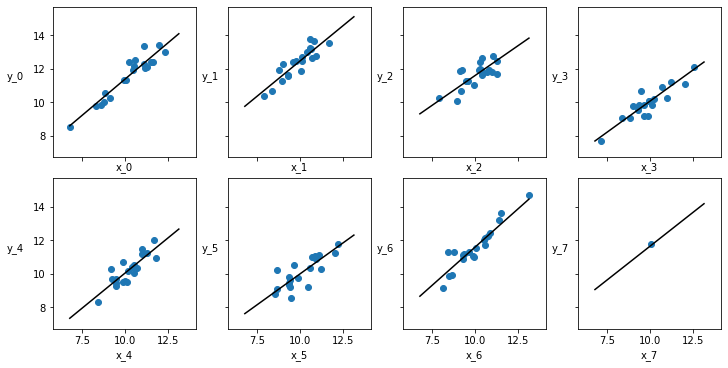

In [102]:
# hierachical
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
    label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

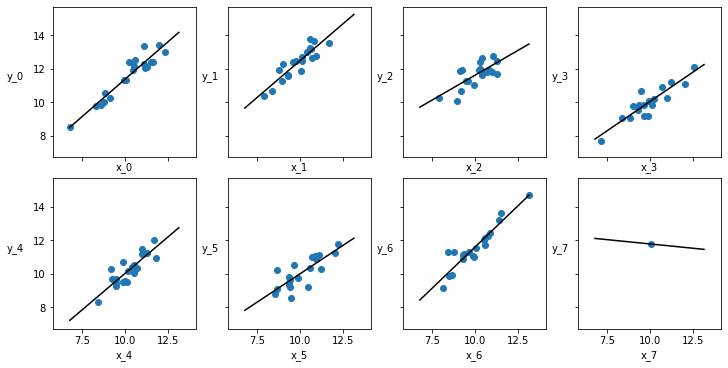

In [103]:
# Not hierachical

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_up['α'][:, i].mean()
    beta_m = trace_up['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
    label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

Text(0, 0.5, 'y')

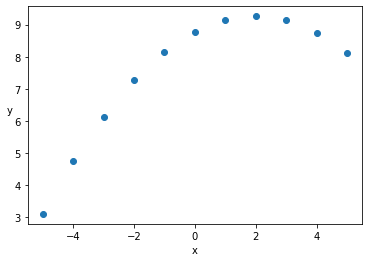

In [104]:
# Polynomial regression

x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [105]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    mu = α + β1 * x_2 + β2 * x_2**2
    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)
    trace_poly = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1378224651.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_poly = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 69 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


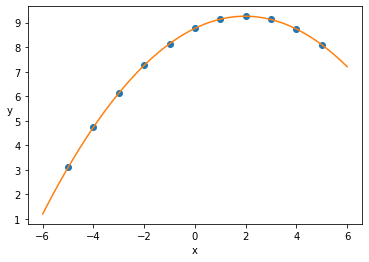

In [106]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * \
x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')

Text(0, 0.5, 'y')

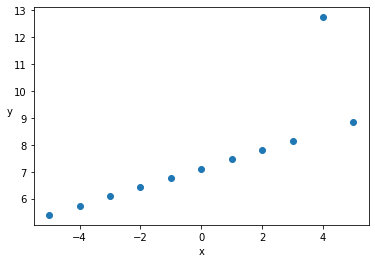

In [107]:
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()
plt.scatter(x_3, y_3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [111]:
with pm.Model() as model_poly_p:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    #β3 = pm.Normal('β3', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    mu = α + β1 * x_3 + β2 * x_3**2 # +β3 * x_3**3
    y_pred_p = pm.Normal('y_pred_p', mu=mu, sd=ϵ, observed=y_3)
    trace_poly_p = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/3292241338.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_poly_p = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.


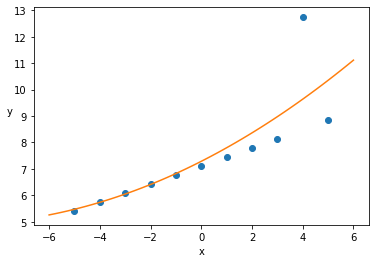

In [112]:
x_p2 = np.linspace(-6, 6)
y_p2 = trace_poly_p['α'].mean() + trace_poly_p['β1'].mean() * \
x_p2 + trace_poly_p['β2'].mean() * x_p**2 #+ trace_poly_p['β3'].mean() * x_p**3
plt.scatter(x_3, y_3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p2, y_p2, c='C1')

## Multiple Linear Regression

$$ \begin{align*} \mu &= \alpha + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_m x_m \ &= \sum_{i=1}^{n} \beta_i x_i \ &= \alpha + X \beta \end{align*} $$

In [ ]:
#Draw random samples from a normal (Gaussian) distribution

In [119]:
np.array([np.random.normal(3, 2.5, size=2), np.random.normal(5, 2.5, size=2)])

array([[4.63033657, 4.57253277],
       [8.22705011, 6.1550617 ]])

In [120]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [130]:
X.mean(axis=0, keepdims=True) # mean in column

array([[10.1291923 ,  1.99519902]])

In [131]:
for i, j in zip([10, 2], [1, 1.5]):
    print(i,j)

10 1
2 1.5


In [133]:
X.ndim

2

In [134]:
X.shape

(100, 2)

In [135]:
X.size

200

In [136]:
X_centered.ndim

2

In [137]:
X_centered.shape

(100, 2)

In [139]:
X_centered.size

200

In [140]:
X_centered[0]

array([0.05718761, 1.37664742])

In [141]:
X_centered[1]

array([-1.66293726,  0.8472022 ])

In [149]:
X_mean[:1]

array([[10.1291923 ,  1.99519902]])

In [151]:
X.shape

(100, 2)

In [152]:
X_mean.shape

(1, 2)

In [154]:
# we define a function to draw a scatter plot
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
        
    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

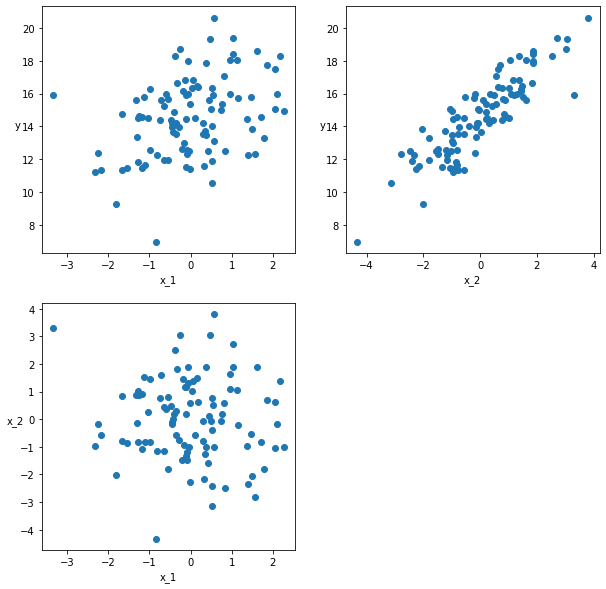

In [155]:
scatter_plot(X_centered, y)

In [158]:
# now we will built the model for multiple linear regression
# some precision the variable beta is a Gaussian with shape=2, one slope per each independent variable
# we define the variable μ using the dot product function pm.math.dot()

with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α_tmp + pm.math.dot(X_centered, β) #this is a matrix product  with a Theano matrix multiplication
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_mlr = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/4035799030.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_mlr = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


In [161]:
with model_mlr:
    varnames = ['α', 'β', 'ϵ']
    trace_mlr_sum =az.summary(trace_mlr, var_names=varnames)
trace_mlr_sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.851,0.459,0.954,2.657,0.004,0.003,11960.0,6022.0,1.0
β[0],0.969,0.044,0.891,1.056,0.000,0.000,12370.0,6156.0,1.0
β[1],1.470,0.032,1.409,1.530,0.000,0.000,10694.0,6448.0,1.0
ϵ,0.473,0.035,0.409,0.538,0.000,0.000,10820.0,5332.0,1.0


### Counfounding variables and redundant variables

In [174]:
np.random.normal(size=2).mean()

0.4076252375953617

In [175]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1) #scale is equivalent to sd
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [186]:
np.vstack((x_1, x_2)).shape

(2, 100)

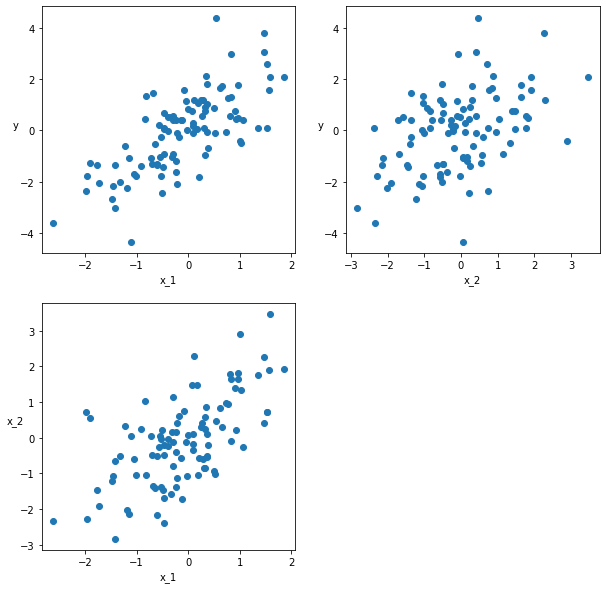

In [188]:
scatter_plot(X,y)

In [189]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1x2 = pm.sample(2000)
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1 = pm.sample(2000)
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x2 = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1127632509.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.
C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1127632509.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.
C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1127632509.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 69 seconds.


D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

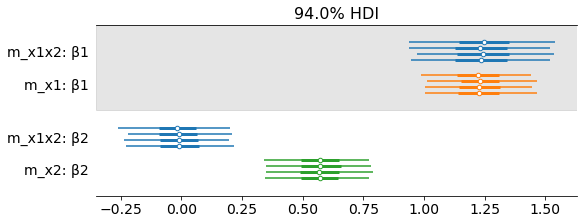

In [190]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2], 
               model_names=['m_x1x2', 'm_x1', 'm_x2'], 
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))

In [ ]:
# As we can see, β_2 for model m_x1x2 is around zero, indicating an almost null contribution
# of the x_2 variable to explain . This is interesting because we already know (check the
# synthetic data) that the really important variable is x_1 . Also notice—and this is really
# important—that β_2 for model m_x2 is around 0.55. This is larger than for model m_x1x2.
# The power of x_2 to predict is reduced when we take into account x_1; the information in
# is redundant given .

## Multicollinearity or when the correlation is too high

In [191]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
#x_2 = x_1 + np.random.normal(size=N, scale=1) #scale is equivalent to sd
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

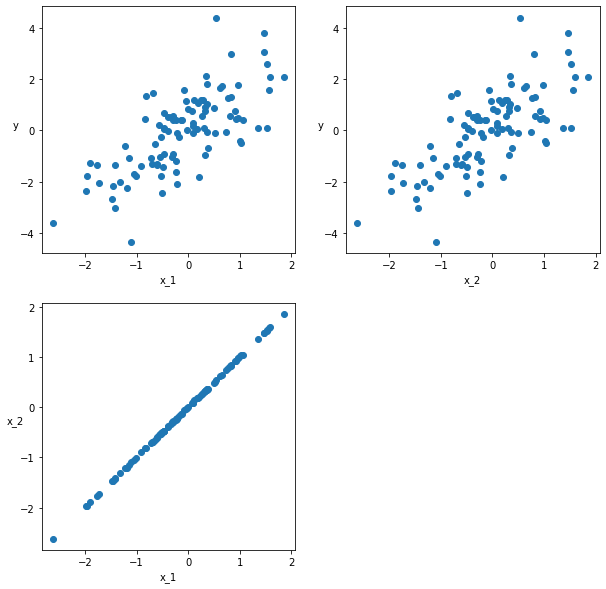

In [192]:
scatter_plot(X,y)

In [193]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + pm.math.dot(X, β)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_red = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1109971252.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_red = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 239 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8836649937075273, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


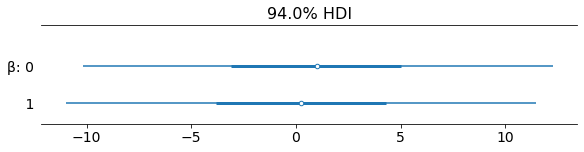

In [194]:
# we check result for the \beta parameter
with model_red:
    az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8,2))

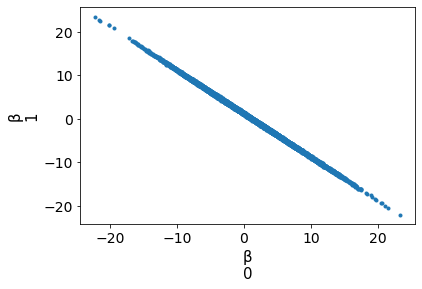

In [196]:
# show on plot both beta
with model_red:
    az.plot_pair(trace_red, var_names=['β'])

## Masking effect

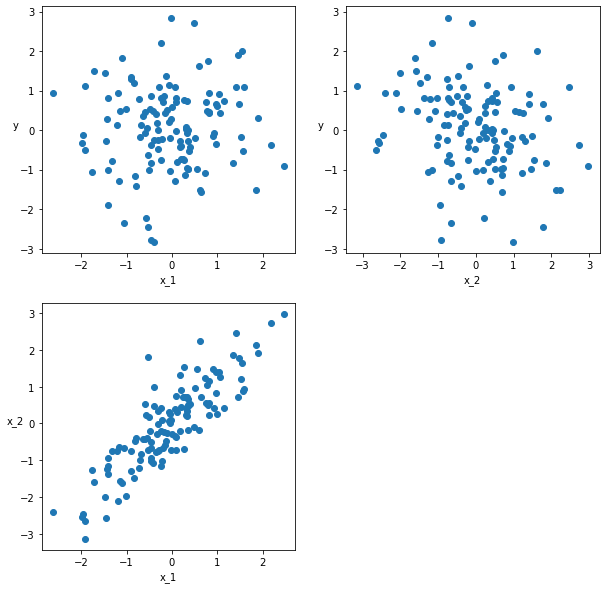

In [197]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T
scatter_plot(X, y)

In [198]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1x2 = pm.sample(2000)
with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x1 = pm.sample(2000)
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)
    trace_x2 = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1127632509.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 71 seconds.
The acceptance probability does not match the target. It is 0.8973486837163516, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1127632509.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.
C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1127632509.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

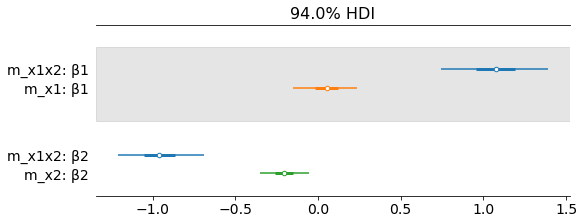

In [199]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))

## Variable variance

<AxesSubplot:xlabel='Month', ylabel='Lenght'>

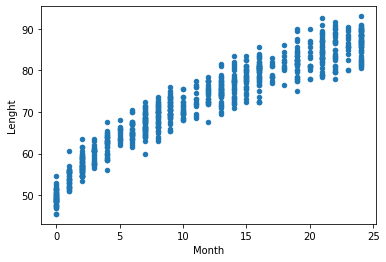

In [201]:
data = pd.read_csv('C:/Users/kamguia_l/Documents/data/babies.csv')
data.plot.scatter('Month', 'Lenght')

In [206]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)
    
    x_shared = shared(data.Month.values * 1.)
    
    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Lenght)
    trace_vv = pm.sample(1000, tune=1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/2866530144.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_vv = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ, γ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Text(0, 0.5, 'y')

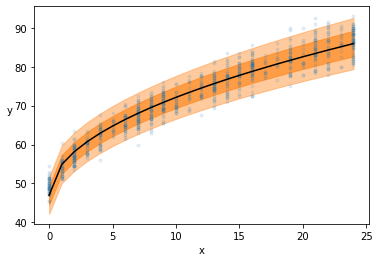

In [207]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)
μ_m = trace_vv['μ'].mean(0)
ϵ_m = trace_vv['ϵ'].mean(0)
plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, μ_m + 1 * ϵ_m, μ_m -
1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, μ_m + 2 * ϵ_m, μ_m -
2 * ϵ_m, alpha=0.4, color='C1')
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [208]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [310]:
y_ppc.size

2000

In [318]:
x_shared.index

In [311]:
ref = 47.5
density, l, u =  az.numeric_utils._fast_kde(y_ppc) 
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()

AttributeError: module 'arviz' has no attribute 'numeric_utils'

## Exercices

## Exercice 1 - 5

In [214]:
#done in the book

# Exercice 6

In [215]:
# Execute model_g using NUTS (the default sampler) and then using Metropolis. Compare the results using ArviZ functions like plot_trace and plot_pair.
# Center the variable x and repeat the exercise. What conclusion can you draw from this?

In [225]:
with pm.Model() as model_g_6:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x) # we could have ommited this instruction but at that time the x variable 
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) # will be calculated but not stored y_pred = pm.Normal('y_pred', mu= α + β * x, sd=ϵ, observed=y)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    trace_g_6 = pm.sample(2000, tune=1000, step = step)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/3714131716.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g_6 = pm.sample(2000, tune=1000, step = step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


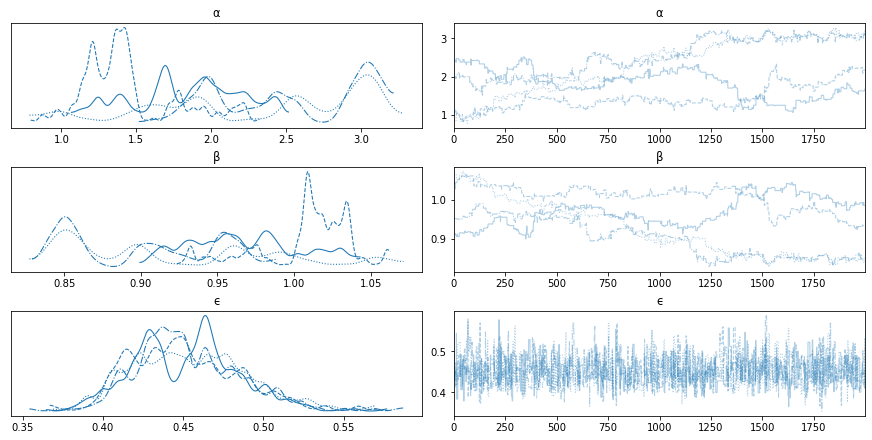

In [226]:
with model_g_6:
    az.plot_trace(trace_g_6, var_names=['α', 'β', 'ϵ'] )

D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


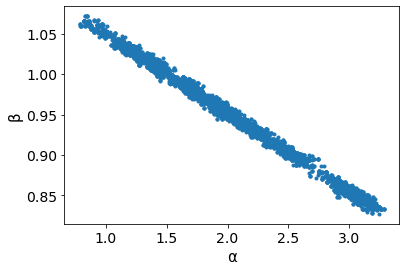

In [227]:
with model_g_6:
    az.plot_pair(trace_g_6, var_names=['α', 'β'], plot_kwargs={'alpoha':0.8})

In [228]:
x_centered = x - x.mean()
with pm.Model() as model_g_6b:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x_centered) # we could have ommited this instruction but at that time the x variable 
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) # will be calculated but not stored y_pred = pm.Normal('y_pred', mu= α + β * x, sd=ϵ, observed=y)
    
    # instantiate sampler
    step = pm.Metropolis()
    
    trace_g_6b = pm.sample(2000, tune=1000, step = step)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/257010803.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g_6b = pm.sample(2000, tune=1000, step = step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ϵ]
>Metropolis: [β]
>Metropolis: [α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.


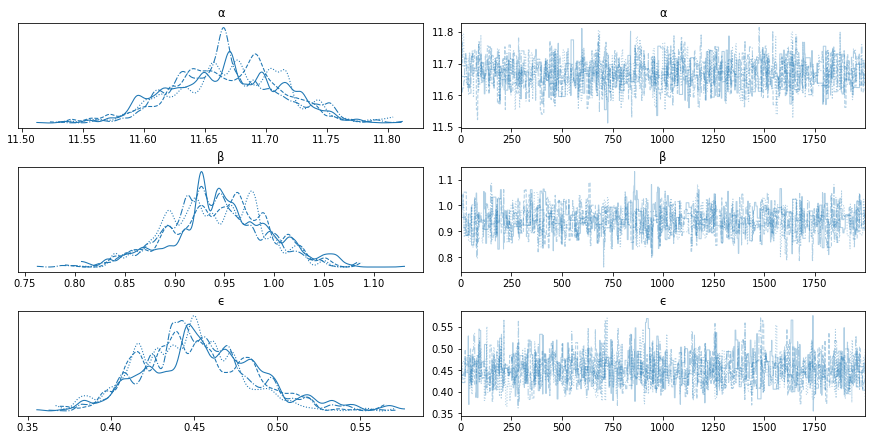

In [229]:
with model_g_6b:
    az.plot_trace(trace_g_6b, var_names=['α', 'β', 'ϵ'] )

D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


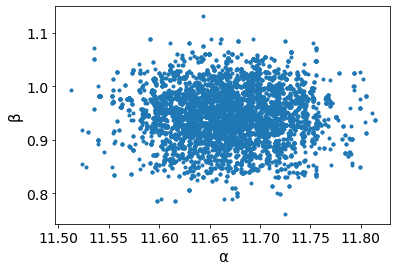

In [230]:
with model_g_6b:
    az.plot_pair(trace_g_6b, var_names=['α', 'β'], plot_kwargs={'alpoha':0.1})

In [231]:
# conclusion is that Metropolis method is too sensitive to not centred data
# the preprocessing of data is really important

# Exercice 7

In [232]:
# Using the howell dataset (available at https://github.com/aloctavodia/BAP) to create a linear model of the weight ( x) against the height (y). Exclude subjects
# that are younger than 18. Explain the results.

In [243]:
how = pd.read_csv("C:/Users/kamguia_l/Documents/data/howell.csv", sep=";", header=0 )

In [244]:
how.tail()

,height,weight,age,male
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1
543,158.750,52.531624,68.0,1


In [248]:
how_pro = how[how.age>18]

In [249]:
how_pro.describe()

,height,weight,age,male
count,346.000000,346.000000,346.000000,346.000000
mean,154.644369,45.045543,41.539740,0.473988
std,7.773564,6.455220,15.809304,0.500046
min,136.525000,31.524644,19.000000,0.000000
25%,148.590000,40.334251,29.000000,0.000000
50%,154.305000,45.004831,40.000000,0.000000
75%,160.655000,49.377742,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


Text(0.5, 0, 'height')

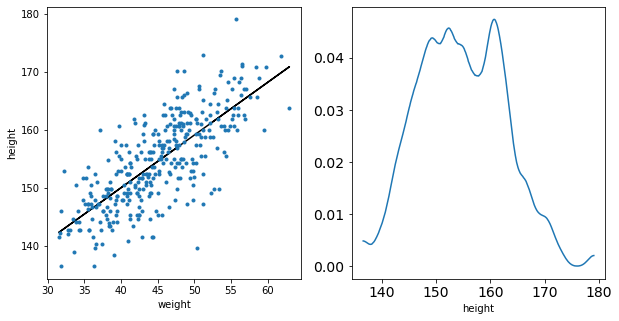

In [271]:
x_7 = how_pro['weight'].values
y_7 = how_pro['height'].values

# Now, let's check what this little tiny dataset looks like:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_7, alpha_7 = stats.linregress(x_7, y_7)[:2]
ax[0].plot(x_7, alpha_7 + beta_7*x_7, 'k')
ax[0].plot(how_pro.weight, how_pro.height, 'C0.')
ax[0].set_xlabel('weight')
ax[0].set_ylabel('height')
az.plot_kde(y_7, ax = ax[1])
ax[1].set_xlabel('height')

In [272]:
y_7.mean()

154.64436878612716

In [273]:
with pm.Model() as model_7:
    α = pm.Normal('α', mu = 150, sd = 30)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * x_7)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = y_7)
    
    trace_7 = pm.sample( 2000, tune = 1000)
    

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1123908882.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_7 = pm.sample( 2000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8906495944625176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9099657286060434, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


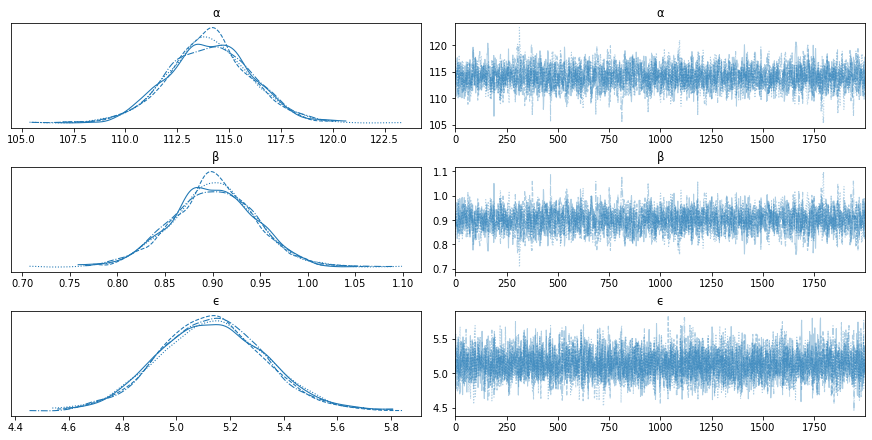

In [274]:
with model_7:
    az.plot_trace(trace_7, var_names=['α', 'β', 'ϵ'])

D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


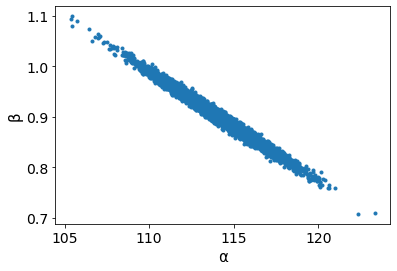

In [275]:
with model_7:
    az.plot_pair(trace_7, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})
#we can observe that there is a problem of correlation between alpha and beta so the model is not good we have to either centering or stansartise data

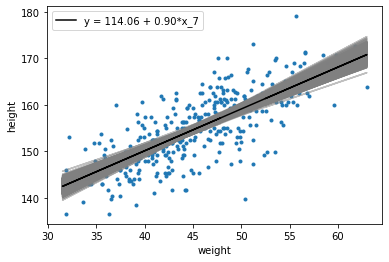

In [281]:
#visualising and interpreting the posterior

plt.plot(x_7, y_7, 'C0.')

alpha_7 = trace_7['α'].mean()
beta_7 = trace_7['β'].mean()

plt.plot(x_7, trace_7['α'] + trace_7['β'] * x_7[:, np.newaxis], c='gray', alpha=0.5) # all line
plt.plot(x_7, alpha_7 + beta_7 * x_7, c='k', alpha=1, label=f'y = {alpha_7:.2f} + {beta_7:.2f}*x_7') # mean line 

plt.xlabel('weight')
plt.ylabel('height')
plt.legend()

D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


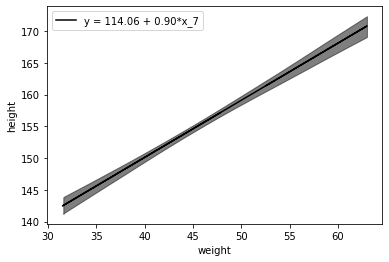

In [283]:
# with hpi interval
plt.plot(x_7, alpha_7 + beta_7 * x_7, c='k', alpha=1, label=f'y = {alpha_7:.2f} + {beta_7:.2f}*x_7') # mean line
az.plot_hdi(x_7, trace_7['μ'], hdi_prob=0.95, color='k') # hdi line with probability of 95%

plt.xlabel('weight')
plt.ylabel('height')
plt.legend()

Text(0, 0.5, 'height')

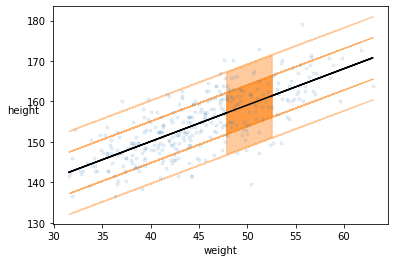

In [381]:
plt.plot(x_7, y_7, 'C0.', alpha=0.1)
μ_m = trace_7['μ'].mean(0)
ϵ_m = trace_7['ϵ'].mean(0)
plt.plot(x_7, μ_m, c='k')
plt.fill_between(how_pro['weight'], μ_m + 1 * ϵ_m, μ_m -1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(x_7, μ_m + 2 * ϵ_m, μ_m -2 * ϵ_m, alpha=0.4, color='C1')
plt.xlabel('weight')
plt.ylabel('height', rotation=0)

In [287]:
# Robust linear regression by centering x_7 and using of Student distribution as likelihood

x_7b = x_7 - x_7.mean()

with pm.Model() as model_7b:
    α = pm.Normal('α', mu= y_7.mean(),  sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29) # exponential function
    ν = pm.Deterministic('ν', ν_ + 1) # shifted exponential function distribution
    
    y_pred = pm.StudentT('y_pred', mu=α + β * x_7b, sd = ϵ, nu = ν, observed = y_7)
    
    trace_7b = pm.sample(2000)


C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1474830492.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_7b = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


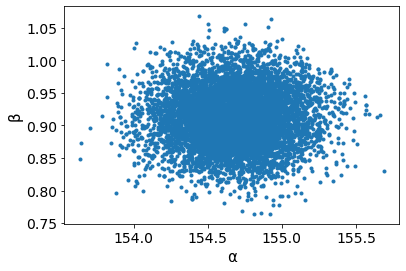

In [288]:
with model_7b:
    az.plot_pair(trace_7b, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

In [297]:
az.summary(trace_7b, var_names=['α', 'β', 'ϵ', 'ν'])

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,154.680,0.273,154.179,155.201,0.003,0.002,6921.0,5285.0,1.0
β,0.913,0.042,0.829,0.987,0.001,0.000,5281.0,5225.0,1.0
ϵ,4.846,0.255,4.338,5.297,0.004,0.003,3963.0,3174.0,1.0
ν,29.162,23.751,4.717,72.002,0.332,0.235,4049.0,4184.0,1.0


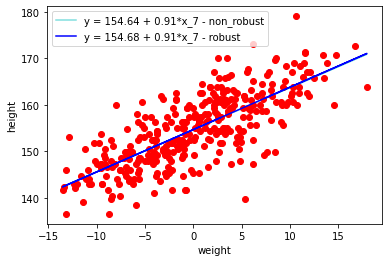

In [296]:
# compare non robust and robust

beta_nr, alpha_nr = stats.linregress(x_7b, y_7)[:2]
plt.plot(x_7b, alpha_nr + beta_nr * x_7b, c='c', alpha=0.5, label=f'y = {alpha_nr:.2f} + {beta_nr:.2f}*x_7 - non_robust') # mean line 
alpha_7b = trace_7b['α'].mean()
beta_7b = trace_7b['β'].mean()
plt.plot(x_7b, y_7, 'ro')
plt.plot(x_7b, alpha_7b + beta_7b * x_7b, c='b', alpha=1, label=f'y = {alpha_7b:.2f} + {beta_7b:.2f}*x_7 - robust') # mean line 


plt.xlabel('weight')
plt.ylabel('height')
plt.legend(loc=2)

# Exercice 8

For four subjects, we get the weights (45.73, 65.8, 54.2, 32.59), but not their heights. Using the model from the previous exercise, predict the height for each subject, together with their HPDs of 50% and 94%.
Tip1: Check coal mining disaster example in the PyMC3 documentation.
Tip2: Use shared variables

In [394]:
with pm.Model() as model_7bbis:
    α = pm.Normal('α', mu= y_7.mean(),  sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29) # exponential function
    ν = pm.Deterministic('ν', ν_ + 1) # shifted exponential function distribution
    
    x_sharedbis = shared(x_7b * 1)
    
    μ = pm.Deterministic('μ', α + β * x_sharedbis)
    
    y_pred = pm.StudentT('y_pred', mu=μ, sd = ϵ, nu = ν, observed = y_7) #make sure to use shared variables
    
    trace_7bbis = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/639535505.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_7bbis = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 77 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [395]:
np.array([45.73, 65.8, 54.2, 32.59] - x_7.mean())

array([  0.68445714,  20.75445714,   9.15445714, -12.45554286])

In [396]:
x_sharedbis.set_value(np.array([45.73, 65.8, 54.2, 32.59] - x_7.mean()))

In [397]:
ppc = pm.sample_posterior_predictive(trace_7bbis, 2000, model=model_7bbis)

D:\Anaconda\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [398]:
ppc['y_pred'].shape

(2000, 4)

In [432]:
#here is mean prediction for each 
ppc['y_pred'].mean(0)

array([155.38733515, 173.60839641, 162.99928524, 143.25210003])

In [438]:
ppc['y_pred'].mean(0)[0]

155.38733514728162

In [401]:
trace_7bbis['μ'].shape

(8000, 346)

In [406]:
x_7b.shape

(346,)

In [410]:
x_sharedbis.get_value().shape, ppc['y_pred'].shape

((4,), (2000, 4))

D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
D:\Anaconda\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


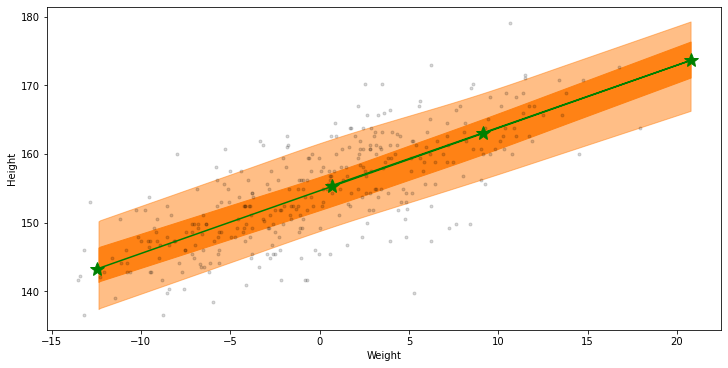

In [449]:
_, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True)

ax.plot(x_7b, y_7, "k.", alpha=0.15)
#az.plot_hdi(x_7b, trace_7bbis['μ'], hdi_prob=0.6, fill_kwargs={"alpha": 0.8})
az.plot_hdi(x_sharedbis.get_value(), ppc['y_pred'], hdi_prob = 0.8, fill_kwargs={"alpha": 0.5})
az.plot_hdi(x_sharedbis.get_value(), ppc['y_pred'], hdi_prob = 0.4, fill_kwargs={"alpha": 0.94})

ax.plot(x_sharedbis.get_value(), ppc['y_pred'].mean(0),  color='g', markersize=15, marker='*')

plt.xlabel("Weight")
plt.ylabel("Height");

In [450]:
ppc['y_pred'][:,0]

array([166.29491846, 152.81841882, 161.4126116 , ..., 158.38692528,
       141.79540414, 153.91568793])

In [451]:
x_sharedbis.get_value()[:1]

array([0.68445714])

In [452]:
ppc.items()

dict_items([('y_pred', array([[166.29491846, 176.93775911, 157.71753679, 146.06878145],
       [152.81841882, 166.46406464, 167.60055359, 144.82408295],
       [161.4126116 , 168.66759279, 162.17593323, 148.90242519],
       ...,
       [158.38692528, 174.83024012, 152.84662461, 134.4872324 ],
       [141.79540414, 171.46946888, 165.07609272, 143.33393391],
       [153.91568793, 172.75848776, 163.81493815, 132.41911011]]))])

# Exercice 9

Repeat exercise 7, this time including those below 18 years old. Explain the results.

In [337]:
with pm.Model() as model_9:
    α = pm.Normal('α', mu = 150, sd = 30)
    β = pm.Normal('β', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β * how.weight)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = how.height)
    
    trace_9 = pm.sample( 2000, tune = 1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1908447046.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_9 = pm.sample( 2000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8942191754822527, but should be close to 0.8. Try to increase the number of tuning steps.


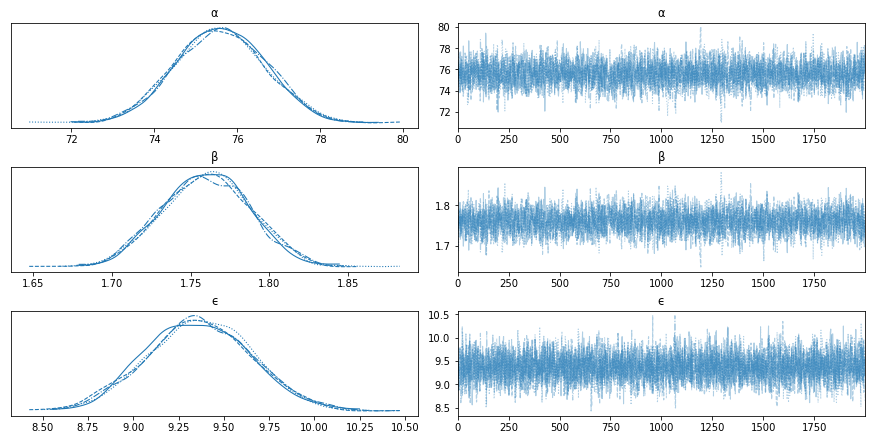

In [338]:
with model_9:
    az.plot_trace(trace_9, var_names=['α', 'β', 'ϵ'])

D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


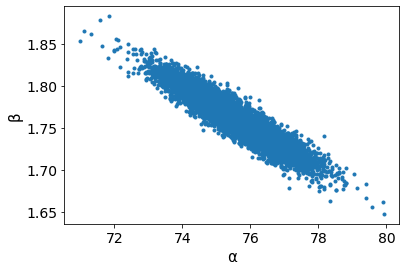

In [339]:
with model_9:
    az.plot_pair(trace_9, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1})

# Exercice 10

It is known for many species that the weight does not scale with the height, but with the logarithm of the weight. Use this information to fit the howell data (including subjects from all ages). Do one more model, this time without using
the logarithm but instead a second order polynomial. Compare and explain both results.

In [457]:
with pm.Model() as model_10:
    α = pm.Normal('α', mu = how.height.mean(), sd = 30)
    β1 = pm.Normal('β1', mu = 0, sd = 1)
    β2 = pm.Normal('β2', mu = 0, sd = 1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    
    μ = pm.Deterministic('μ', α + β1 * how.weight + β2 * how.weight**2)
    y_pred = pm.Normal('y_pred', mu = μ, sd = ϵ, observed = how.height)
    
    trace_10 = pm.sample( 2000, tune = 1000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/645803277.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_10 = pm.sample( 2000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 104 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9120130444163128, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9483199674492726, but should be close to 0.8. Try to increase the number of tuning steps.


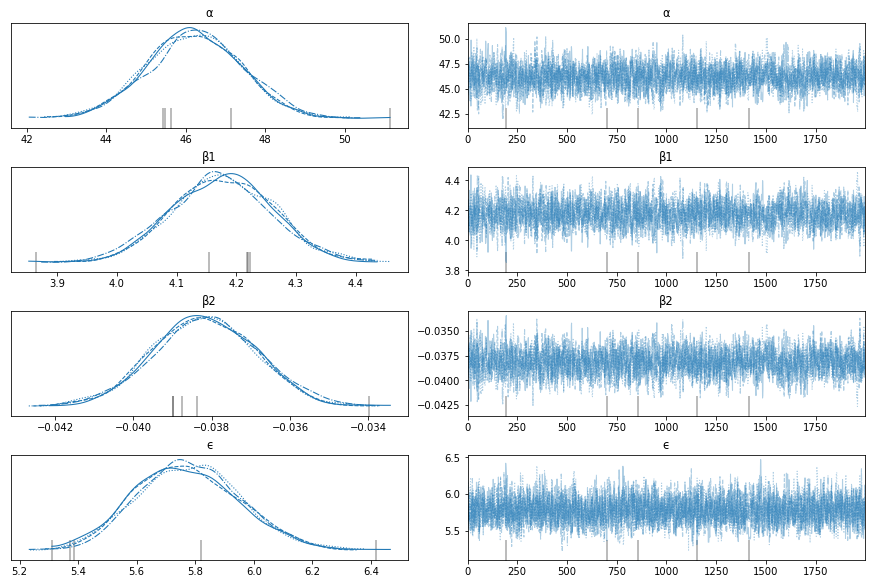

In [458]:
with model_10:
    az.plot_trace(trace_10, var_names=['α', 'β1', 'β2','ϵ'])

In [456]:
how.height.mean()

138.26359632352944

In [460]:
az.summary(trace_10, var_names=['α', 'β1', 'β2', 'ϵ' ])

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,46.210,1.188,44.047,48.484,0.025,0.018,2269.0,2974.0,1.0
β1,4.176,0.084,4.014,4.328,0.002,0.001,2104.0,2622.0,1.0
β2,-0.038,0.001,-0.041,-0.036,0.000,0.000,2201.0,2724.0,1.0
ϵ,5.777,0.177,5.464,6.122,0.003,0.002,3052.0,3146.0,1.0


D:\Anaconda\lib\site-packages\arviz\plots\pairplot.py:185: UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs
  warnings.warn(


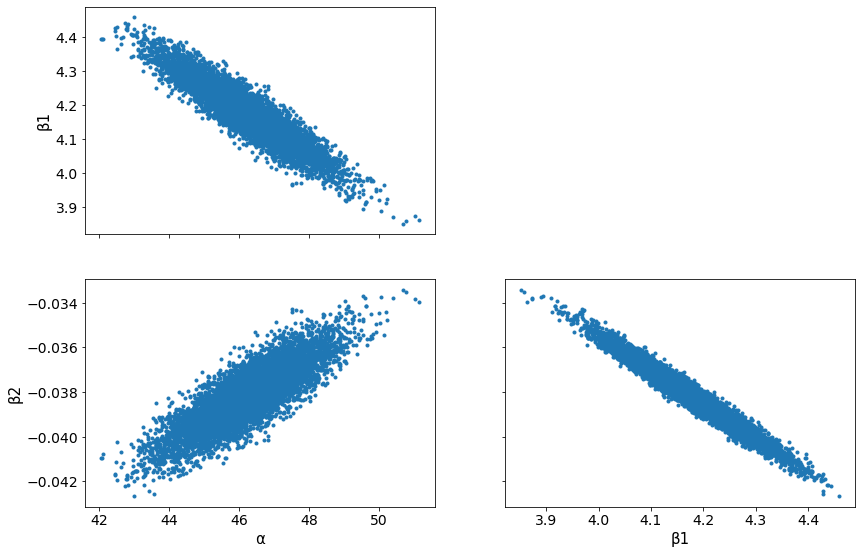

In [461]:
with model_10:
    az.plot_pair(trace_10, var_names=['α', 'β1', 'β2'], plot_kwargs={'alpha': 0.1})

In [ ]:
# All those models are not good ones

# Exercice 11

# Exercise 12

See in the accompanying code the model_t2 (and the data associated with it).
Experiment with priors for \nu , like the non-shifted exponential and gamma priors
(they are commented in the code). Plot the prior distribution to ensure that you
understand them. An easy way to do this is to just comment the likelihood in the
model and check the trace plot. A more efficient way is to use the
pm.sample_prior_predictive() function instead of pm.sample().

In [462]:
ans = pd.read_csv("C:/Users/kamguia_l/Documents/data/anscombe.csv")
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

In [463]:
with pm.Model() as model_t12a:   #non shiftd exponential
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)

    y_preda = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν_, observed=y_3)

    trace_t12a = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/3227323372.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t12a = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 176 seconds.
The acceptance probability does not match the target. It is 0.3192814406013756, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.3864583959693632, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1984 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7152363925333919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.00048429178799183013, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.


In [ ]:
varnames = ['α', 'β', 'ϵ', 'ν_']
az.plot_trace(trace_t12a, var_names=varnames)

D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [ ]:
with pm.Model() as model_t12a:   #non shiftd exponential
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)

    y_preda = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν_, observed=y_3)

    prior_check12a = pm.sample_prior_predictive(2000, random_seed=123)

In [ ]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

In [465]:
with pm.Model() as model_t12b:  #gamma 2, .1
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Gamma('ν_',2, 0.1) 

    y_predb = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν_, observed=y_3)

    trace_t12b = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/1299349131.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t12b = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 289 seconds.
The acceptance probability does not match the target. It is 8.051610111958971e-05, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.19100111690370006, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.08546216989667604, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
D:\Anaconda\lib\site-packages\arviz\stats\density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
D:\Anaconda\lib\site-packages\arviz\stats\density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
D:\Anaconda\lib\site-packages\arviz\stats\density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
D:\Anaconda\lib\site-packages\arviz\stats\density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  

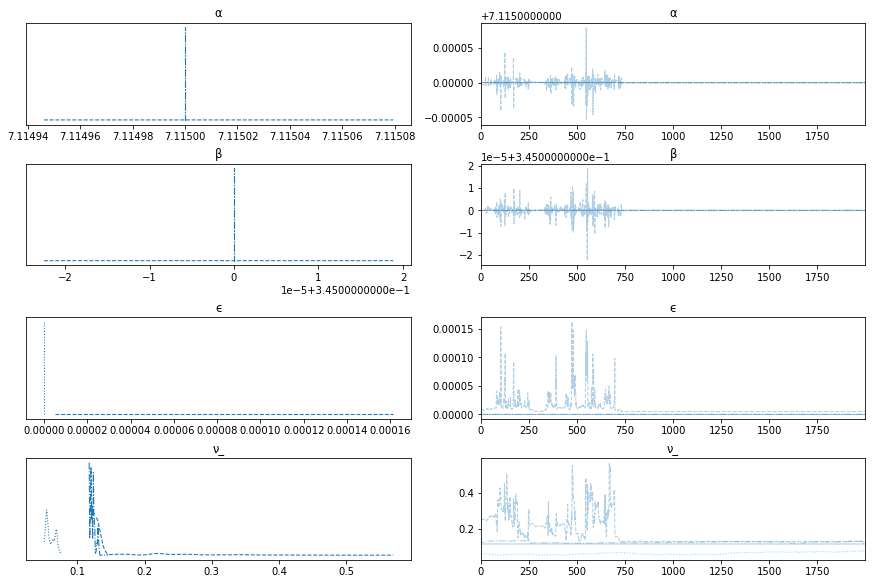

In [466]:
varnames = ['α', 'β', 'ϵ', 'ν_']
az.plot_trace(trace_t12b, var_names=varnames);

In [467]:
with pm.Model() as model_t12c:  #gamma 20 15
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Gamma('ν_',20, 15)

    y_predc = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν_, observed=y_3)

    trace_t12c = pm.sample(2000)

C:\Users\KAMGUI~1\AppData\Local\Temp/ipykernel_11296/3580503236.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t12c = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 77 seconds.
The acceptance probability does not match the target. It is 0.6153480352577563, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7179540852718532, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


D:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


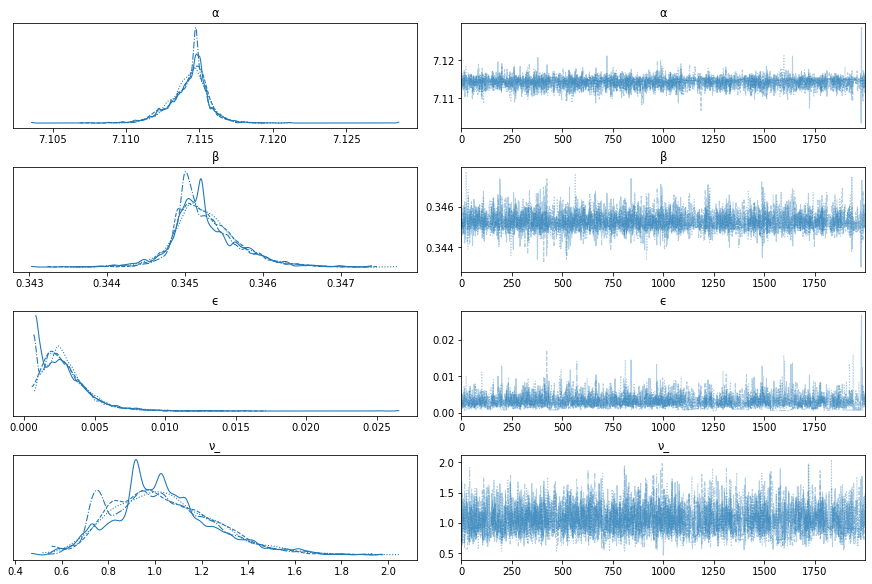

In [468]:
varnames = ['α', 'β', 'ϵ', 'ν_']
az.plot_trace(trace_t12c, var_names=varnames);

# Exercise 13

## Exercise 14

## Exercise 15

Re-run the model_mlr example, this time without centering the data. Compare the uncertainty in the parameter \alpha for one case and the other. Can you explain
these results?
Tip: Remember the definition of the parameter (also known as the intercept).

# Exercice 16

Read and run the following notebook from PyMC3's documentation: https://pymc-devs.github.io/pymc3/notebooks/LKJ.html.

# Exercice 17

Choose a dataset that you find interesting and use it with the simple linear regression model. Be sure to explore the results using ArviZ functions and compute the Pearson correlation coefficient. If you do not have an interesting dataset, try searching online, for example, at http://data.worldbank.org/ or http://www.stat.ufl.edu/~winner/datasets.html.